In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *
import time

from ROOT import TProfile, TGraphErrors, TH2F, TLegend
import ROOT

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

# print(time.time())
# print(time.gmtime(0))

In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'
Norm = mpl.colors.LogNorm(vmin=10**-1, vmax=7 * 10**0)

Filename: ../images/ENE2025/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 400)   float32   
  1                1 ImageHDU       164   (700, 400)   float32   
  2                1 ImageHDU       164   (700, 400)   float32   
  3                1 ImageHDU       164   (700, 400)   float32   
None
----------------


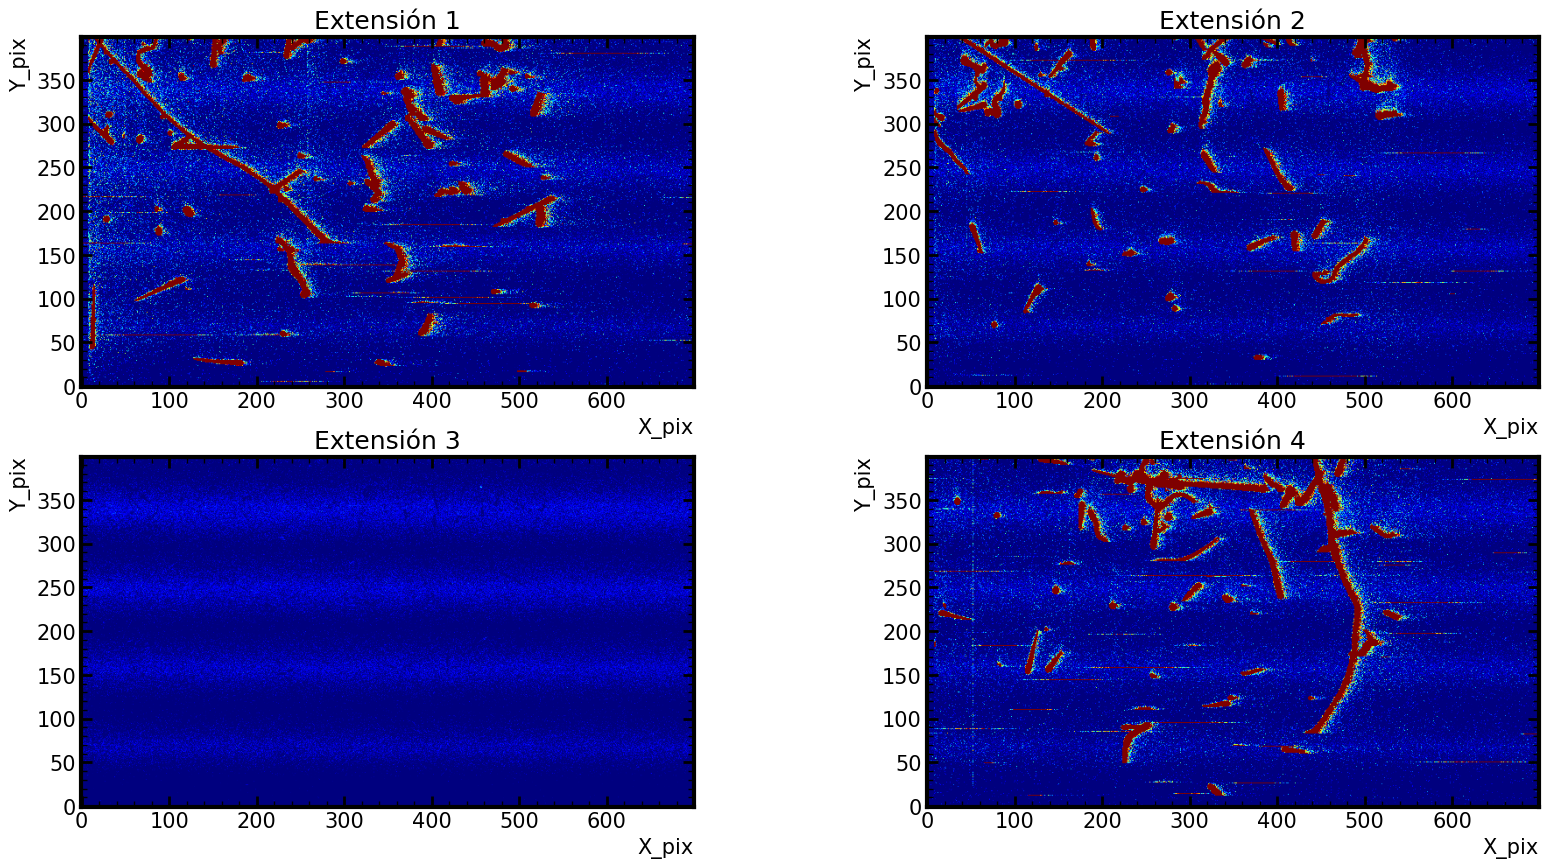

In [3]:
path = '../images/ENE2025/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_101.fits'
# path = '../images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_201.fits'

# path = '/home/bruce/Downloads/proc_skp_m_009_microchip_T_170_Vv82_NSAMP_324_NROW_100_NCOL_700.fits'



hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin = 10, vmax = 1000, cmap = Colormap)
    # plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=100,vmax=1000, cmap = 'gray')
    plt.title('Extensión '+str(i+1))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

In [4]:
extension = 2

## Sustrayendo la media del renglon

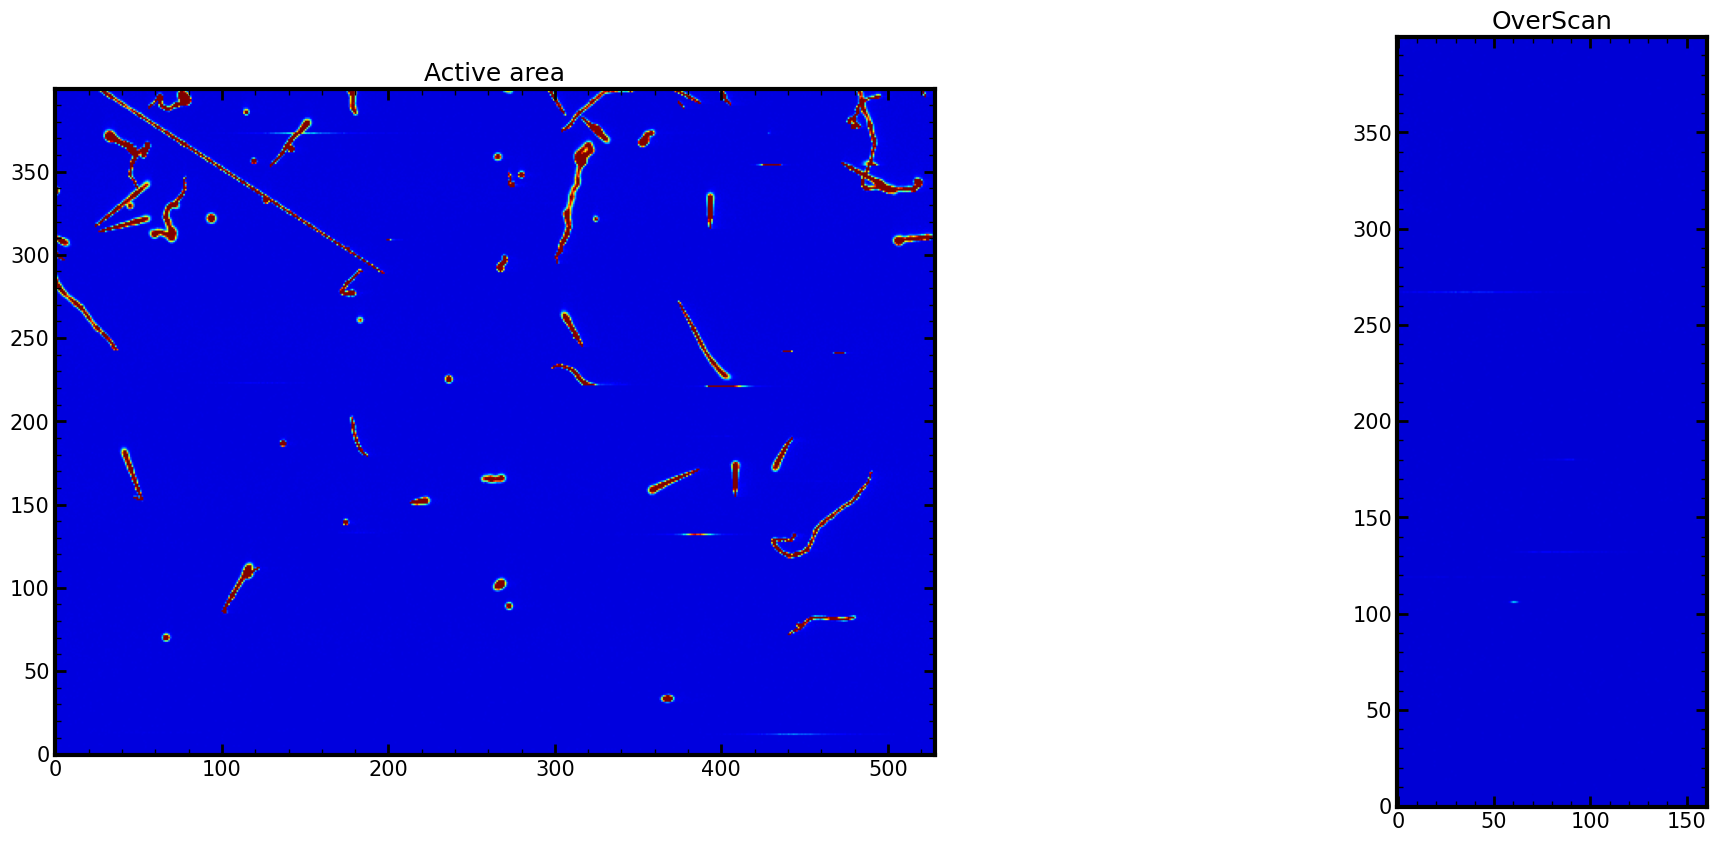

In [5]:
### Muestra el area activa y overscan de la extensión 
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
# Overscan = hdu_list[extension - 1].data[:300, 539:]
# active_area = hdu_list[extension - 1].data[:300, 10:539]

# Overscan = hdu_list[extension - 1].data[:250, 539:]
# active_area = hdu_list[extension - 1].data[:250, 10:539]

Overscan = hdu_list[extension - 1].data[:, 539:]
active_area = hdu_list[extension - 1].data[:, 10:539]


fig, axs = plt.subplots(1,2, figsize=[25,10])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs[0].imshow(active_area, origin='lower', vmin = 100, vmax = 100000, cmap = Colormap)
axs[0].set_title('Active area')

axs[1].imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000, cmap = Colormap)
axs[1].set_title('OverScan')

# plt.colorbar()
plt.show()

# fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


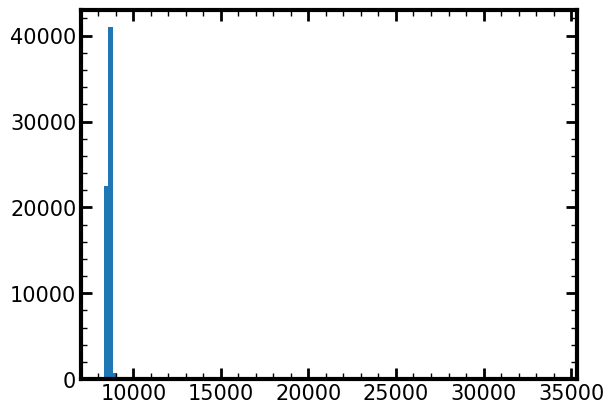

In [6]:
plt.hist(Overscan.flatten(), bins = 100)
# plt.yscale('log')
plt.show()

In [7]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (400, 161)
Dimensiones ActA:  (400, 529)


In [8]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
medi_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    medi_value = np.median(row)
    medi_rows_value.append([medi_value])
    # print((num_row, mean_value))

print(medi_rows_value[0])

[np.float32(8486.479)]


In [9]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - medi_rows_value
print(active_area[1][1])
print(true_active_area[1][1])
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan
min_oScan = np.min(true_Oscan)
# plt.imshow(true_active_area, origin='lower')

8516.164
33.155273


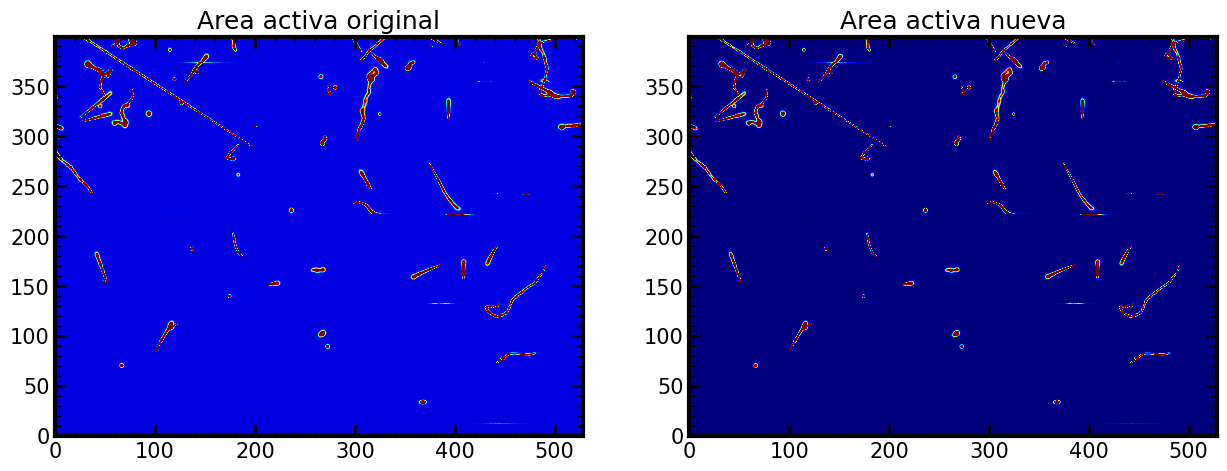

In [10]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 10
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax, cmap = Colormap)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax, cmap = Colormap)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

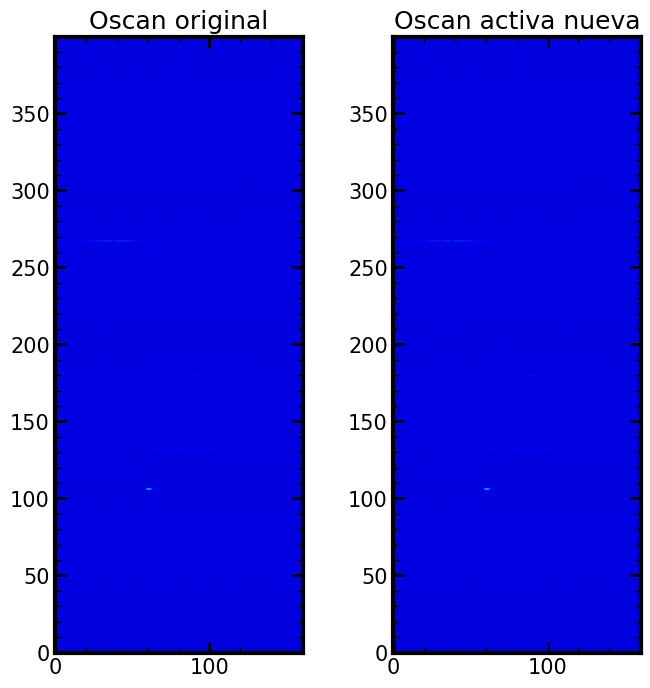

In [11]:
fig, axs = plt.subplots(1, 2, figsize=[8,8])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 10
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax, cmap = Colormap)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax, cmap = Colormap)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

/tmp/ipykernel_6276/3391049149.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


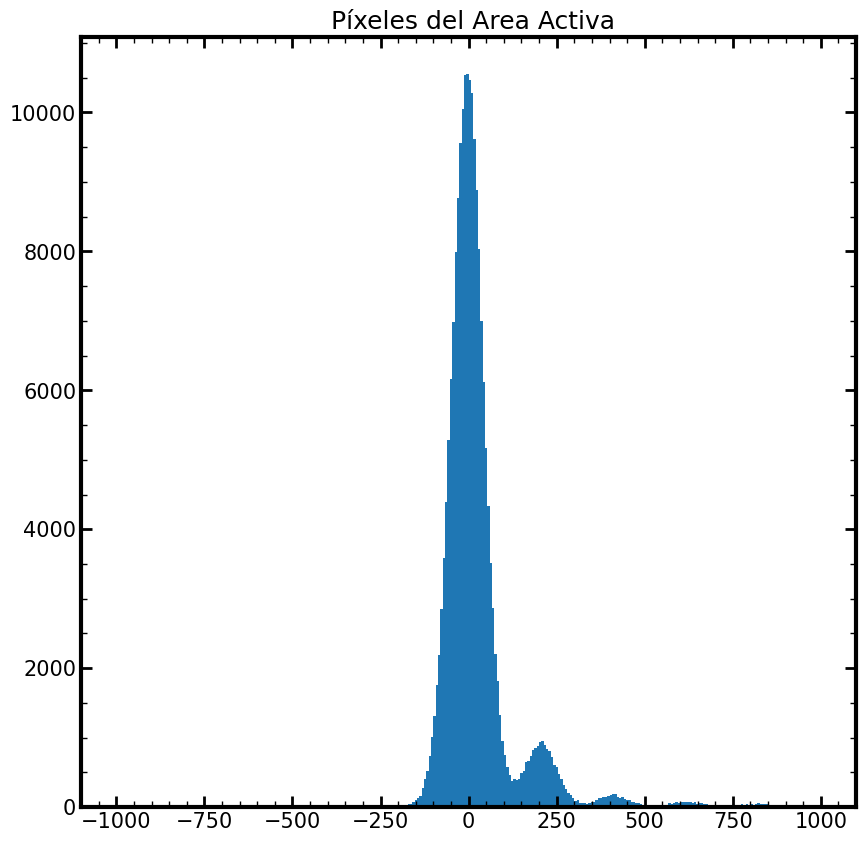

In [12]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

# print(true_Oscan)
min_oScan = np.min(true_Oscan)

# act = true_active_area - offset
## Generamos el histograma de los pixeles del oScan especificando el rango
axs_all.hist(true_active_area.flatten(), bins= 300, range = (-1000, 1000))# , label="Pixeles del Overscan")
# axs_all.hist(active_area.flatten(), bins= 300, range = (-1000, 1000))# , label="Pixeles del Overscan")
# axs_all.hist(true_Oscan.flatten(), bins= 200, range = (8000, 9500))# , label="Pixeles del Overscan")


# axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Area Activa')
plt.legend()

plt.show()

In [13]:
h2=TH1F("histogram", r"Distribucion del Area Activa", 100, -250, 1200)
# h3.AddDirectory(False)
for pixel_value in true_active_area.flatten():
    # if not np.ma.is_masked(pixel_value):
    h2.Fill(pixel_value)
    #print(pixel_value)

c1=TCanvas()
c1.SetLogy()
c1.SetGrid()
h2.SetStats(0)
h2.GetXaxis().SetTitle("Energia (ADUs)")
h2.Draw()
c1.Draw()

## Aplanando el Oscan

### Doble Gaussiana

In [14]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 1000
Bins_fit = Bins
# Range_fit = [-100, 400]

Range_fit = [-50, 350]
ratio_keV = 0.0036  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset 
fgaus2 = TF1("fgaus2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)", Range_fit[0], Range_fit[1],5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", r"Distribucion del Overscan",Bins_fit, -200, 400)
# h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)

fgaus2.SetParameters(0,40,210, 400, 50) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2, "R")


c1=TCanvas()
c1.SetLogy()
c1.SetGrid()
h3.SetStats(0)
h3.GetXaxis().SetTitle("Energ#acute{i}a (ADUs)")
h3.Draw()
fgaus2.GetXaxis().SetRangeUser(-100,10000)
fgaus2.Draw("same")
c1.Draw()

leg = TLegend(0.5, 0.7, 0.9, 0.9)
leg.AddEntry(h3, "Datos", "L")
leg.AddEntry(fgaus2, "Ajuste de doble gaussiana", "L")
leg.Draw()

gStyle.SetOptFit(1100)

# # fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print('First Peak: ', fgaus2.GetParameters()[3],  ' +- ', fgaus2.GetParError(3))
print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


Offset Value:  8577.471  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  9.986695625328387  +-  0.543585886564924
Sigma:  64.73913137023057  +-  0.39278166683853005
Gain:  -284.6840792449515  +-  1.9999999151228245
First Peak:  230.09281881380525  +-  1.0471884664237725
Second Peak:  -1.382421700642552  +-  1.9999951479388152 

chiSquare: 1533.3126317445067
NDegrees of Freedom: 646
Prob: 6.06458110559697e-74 

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1533.31
NDf                       =          646
Edm                       =  2.58383e-06
NCalls                    =          369
p0                        =       9.9867   +/-   0.543586    
p1                        =      64.7391   +/-   0.392782    
p2                        =     -284.684   +/-   2           
p3                        =      230.093   +/-   1.04719     
p4                        =     -1.38242   +/-   2           


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [15]:
delta_Bin = 0
dict_popt =  oScan_fit_NSAMP324_ROOT(extensión = extension, active_area = data, oScan = true_Oscan, Bins = Bins, Bins_fit=Bins_fit,
                                        make_figure_flag = False, range_fit=[-50, 350])


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [16]:
##### Sigma en e- ####
sig_ADUs = dict_popt['sigma']
Gain = dict_popt['Gain']
offset = dict_popt['Offset']

sig_elec = abs(( sig_ADUs) / Gain)
sig_KeV = sig_elec * ratio_keV
print('Gain: ', Gain, ' ADUs/e-')
print('Sigma: ', sig_ADUs, ' ADUs, ', sig_elec, ' e-, ' , sig_KeV, ' KeV')

Gain:  231.10779947598374  ADUs/e-
Sigma:  61.32376085310611  ADUs,  0.2653469982066908  e-,  0.0009552491935440868  KeV


Sigma:  0.0009552491935440868  keV


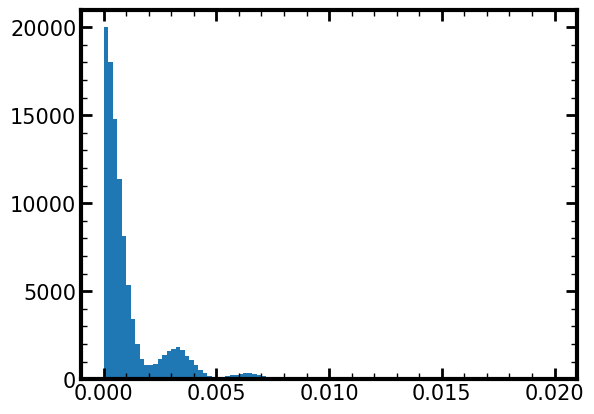

In [17]:
dataCal, sigma = data_calibrated_NSAMP(active_area = true_active_area, extension = extension, offset = offset, gain = Gain, ratio_keV = ratio_keV, unidades = 2, sigma_ADUs = sig_ADUs)
print('Sigma: ', sigma, ' keV')

plt.hist(dataCal.flatten(), bins = 100, range = (0, 0.02))
plt.show()

### Gauss-Poisson

In [64]:
def gauss_comppoisson_fit1(x, par):
    k = 1000
    #  m = 4
    #  ydata = 0;
    xval = x[0]
    a     = par[0]
    mu    = par[1]
    sigma = par[2]
    lambda_poisson = par[3]
    pgeom = par[4]
    gain  = par[5]
    # p=1
    fitval = 0.0
    for p in np.arange(0, k):
        fitval = fitval + a * TMath.Gaus(xval*gain,p-mu,sigma,1) * TMath.PoissonI(p,lambda_poisson)

    return fitval

In [65]:
Bins = 1000
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset

# print(len(Overscan_plane))
# plt.hist(Overscan_plane.flatten(), bins = Bins, range=[-200, 500])

# fit_gausCONVcomppois(Overscan_plane)
data = Overscan_plane.flatten() ## get oScan data and turn 1D array
long_data = len(data)
# print('Ndata: ', long_data)
# print(data)

# print('Voy  a crear y llenar el hist')

histo = TH1F("histo","", Bins, -200, 500)
histo.GetXaxis().SetTitle("charge (e^{-})")

for pixel_value in data:
    # if not np.ma.is_masked(pixel_value):
    histo.Fill(pixel_value)
    # for ibin in np.arange(0, NBins):
    #     histo.SetBinContent(ibin,BinCont[ibin])

    # nevents = histo.Integral()
# print('N_events: ', nevents)
# print('Terminé de llenar todo, ahora haré el ajuste')

npar = 6        # nparameters
norm = 600   
offs = 0    # offset
sigm = 60    # sigma
lamb = 1  # lambda de Poisson
pgeo = 0    # probabilidad (se ignora en el cálculo)
gain = 200

lofit = -100
hifit =  350

fitf = TF1("fitf",gauss_comppoisson_fit1,lofit,hifit,npar)
fitf.SetParameter(0,norm)
fitf.SetParameter(1,offs)
fitf.SetParameter(2,sigm)
fitf.SetParameter(3,lamb)
fitf.SetParameter(4,pgeo)
fitf.SetParameter(5,gain)

# fitf.SetNpx(400)
# fitf.SetMinimum(1e-3)
fitf.SetLineWidth(1)

print('Realizando el ajuste')
# histo.Fit(fitf)
norm = fitf.GetParameter(0)
offs = fitf.GetParameter(1)
sigm = fitf.GetParameter(2)
lamb = fitf.GetParameter(3)
pgeo = fitf.GetParameter(4)
gain = fitf.GetParameter(5)

norme = fitf.GetParError(0)
offse = fitf.GetParError(1)
sigme = fitf.GetParError(2)
lambe = fitf.GetParError(3)
pgeoe = fitf.GetParError(4)
gaine = fitf.GetParError(5)

chisq = fitf.GetChisquare()
ndegf = fitf.GetNDF()
proba = fitf.GetProb()

canv = TCanvas("canv","",600,400)
#histo.Draw()
fitf.Draw("")

canv.Draw()

dict_info = {'par' : {'Offset':offs, 'Sigma':sigm, 'Gain':gain}, 'err' :  {'Offset':offse, 'Sigma':sigme, 'Gain':gaine},
                'fit_quality': {'Chiq' : chisq, 'Ndegf' : ndegf, 'Prob': proba}}

# print(dict_info)
print('Offset fit: ', offs, ' +- ', offse, ' ADUs')
print('Sigma fit: ', sigm, ' +- ', sigme, ' ADUs')
print('Lambda fit: ', lamb, ' +- ', lambe)
print('Gain fit: ', gain, ' +- ', gain, ' e-/ADUs \n\n' )

print('Chiq: ', chisq)
print('Ndegf: ', ndegf)
print('Prob: ', proba)



Offset Value:  15059.678  ADUs
Realizando el ajuste
Offset fit:  0.0  +-  0.0  ADUs
Sigma fit:  60.0  +-  0.0  ADUs
Lambda fit:  1.0  +-  0.0
Gain fit:  200.0  +-  200.0  e-/ADUs 


Chiq:  0.0
Ndegf:  0
Prob:  0.0


Warning in <TROOT::Append>: Replacing existing TH1: histo (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


## Creacción del DataFrame de los clusters detectados

In [18]:
# min_energy_for_label = 100 * sigma
# dataCal = true_active_area
min_energy_for_label = 13* sigma
label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
prop = sk.measure.regionprops(label_img, dataCal)

TotalDataFrame = event_DataFrame(dataCal=dataCal, label_img=label_img, nlabels_img =nlabels_img, 
                                    prop=prop, header=header, extension=extension, unidades = 2)

# TotalDataFrame[2200:2250]

# TotalDataFrame[0:50]
# TotalDataFrame[50:100]
TotalDataFrame[100:150]
# TotalDataFrame[50:100]

Events: 200


,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
101,101,2,20x18,142,271.843933,1.914,"[7.9155, 7.0775]"
102,101,2,1x1,1,0.012613,0.013,"[0.0, 0.0]"
103,101,2,175x111,944,890.325562,0.943,"[81.1303, 59.75]"
104,101,2,13x12,88,132.711929,1.508,"[5.4432, 4.8068]"
105,101,2,1x1,1,0.012529,0.013,"[0.0, 0.0]"
106,101,2,1x1,1,0.015283,0.015,"[0.0, 0.0]"
107,101,2,67x105,1262,1292.832153,1.024,"[20.2575, 64.168]"
108,101,2,2x3,3,0.053381,0.018,"[0.6667, 1.0]"
109,101,2,6x8,27,77.665848,2.877,"[2.0, 2.8148]"


[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


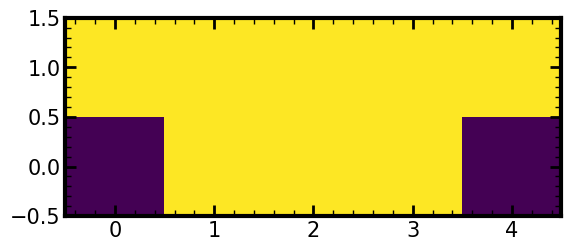

In [140]:
list_example = [[0,0,0,0,0], [0,0,0,0,0], [0,0, True,0,0], [0,0,0,0,0], [0,0,0,0,0]]
skirt = nd.binary_dilation(list_example, iterations=2)
print(skirt)

plt.imshow(skirt[1:3, :])

## Visualizar un cluster y su información

1
Event Slice:
x: [528,529]
y: [267,268]


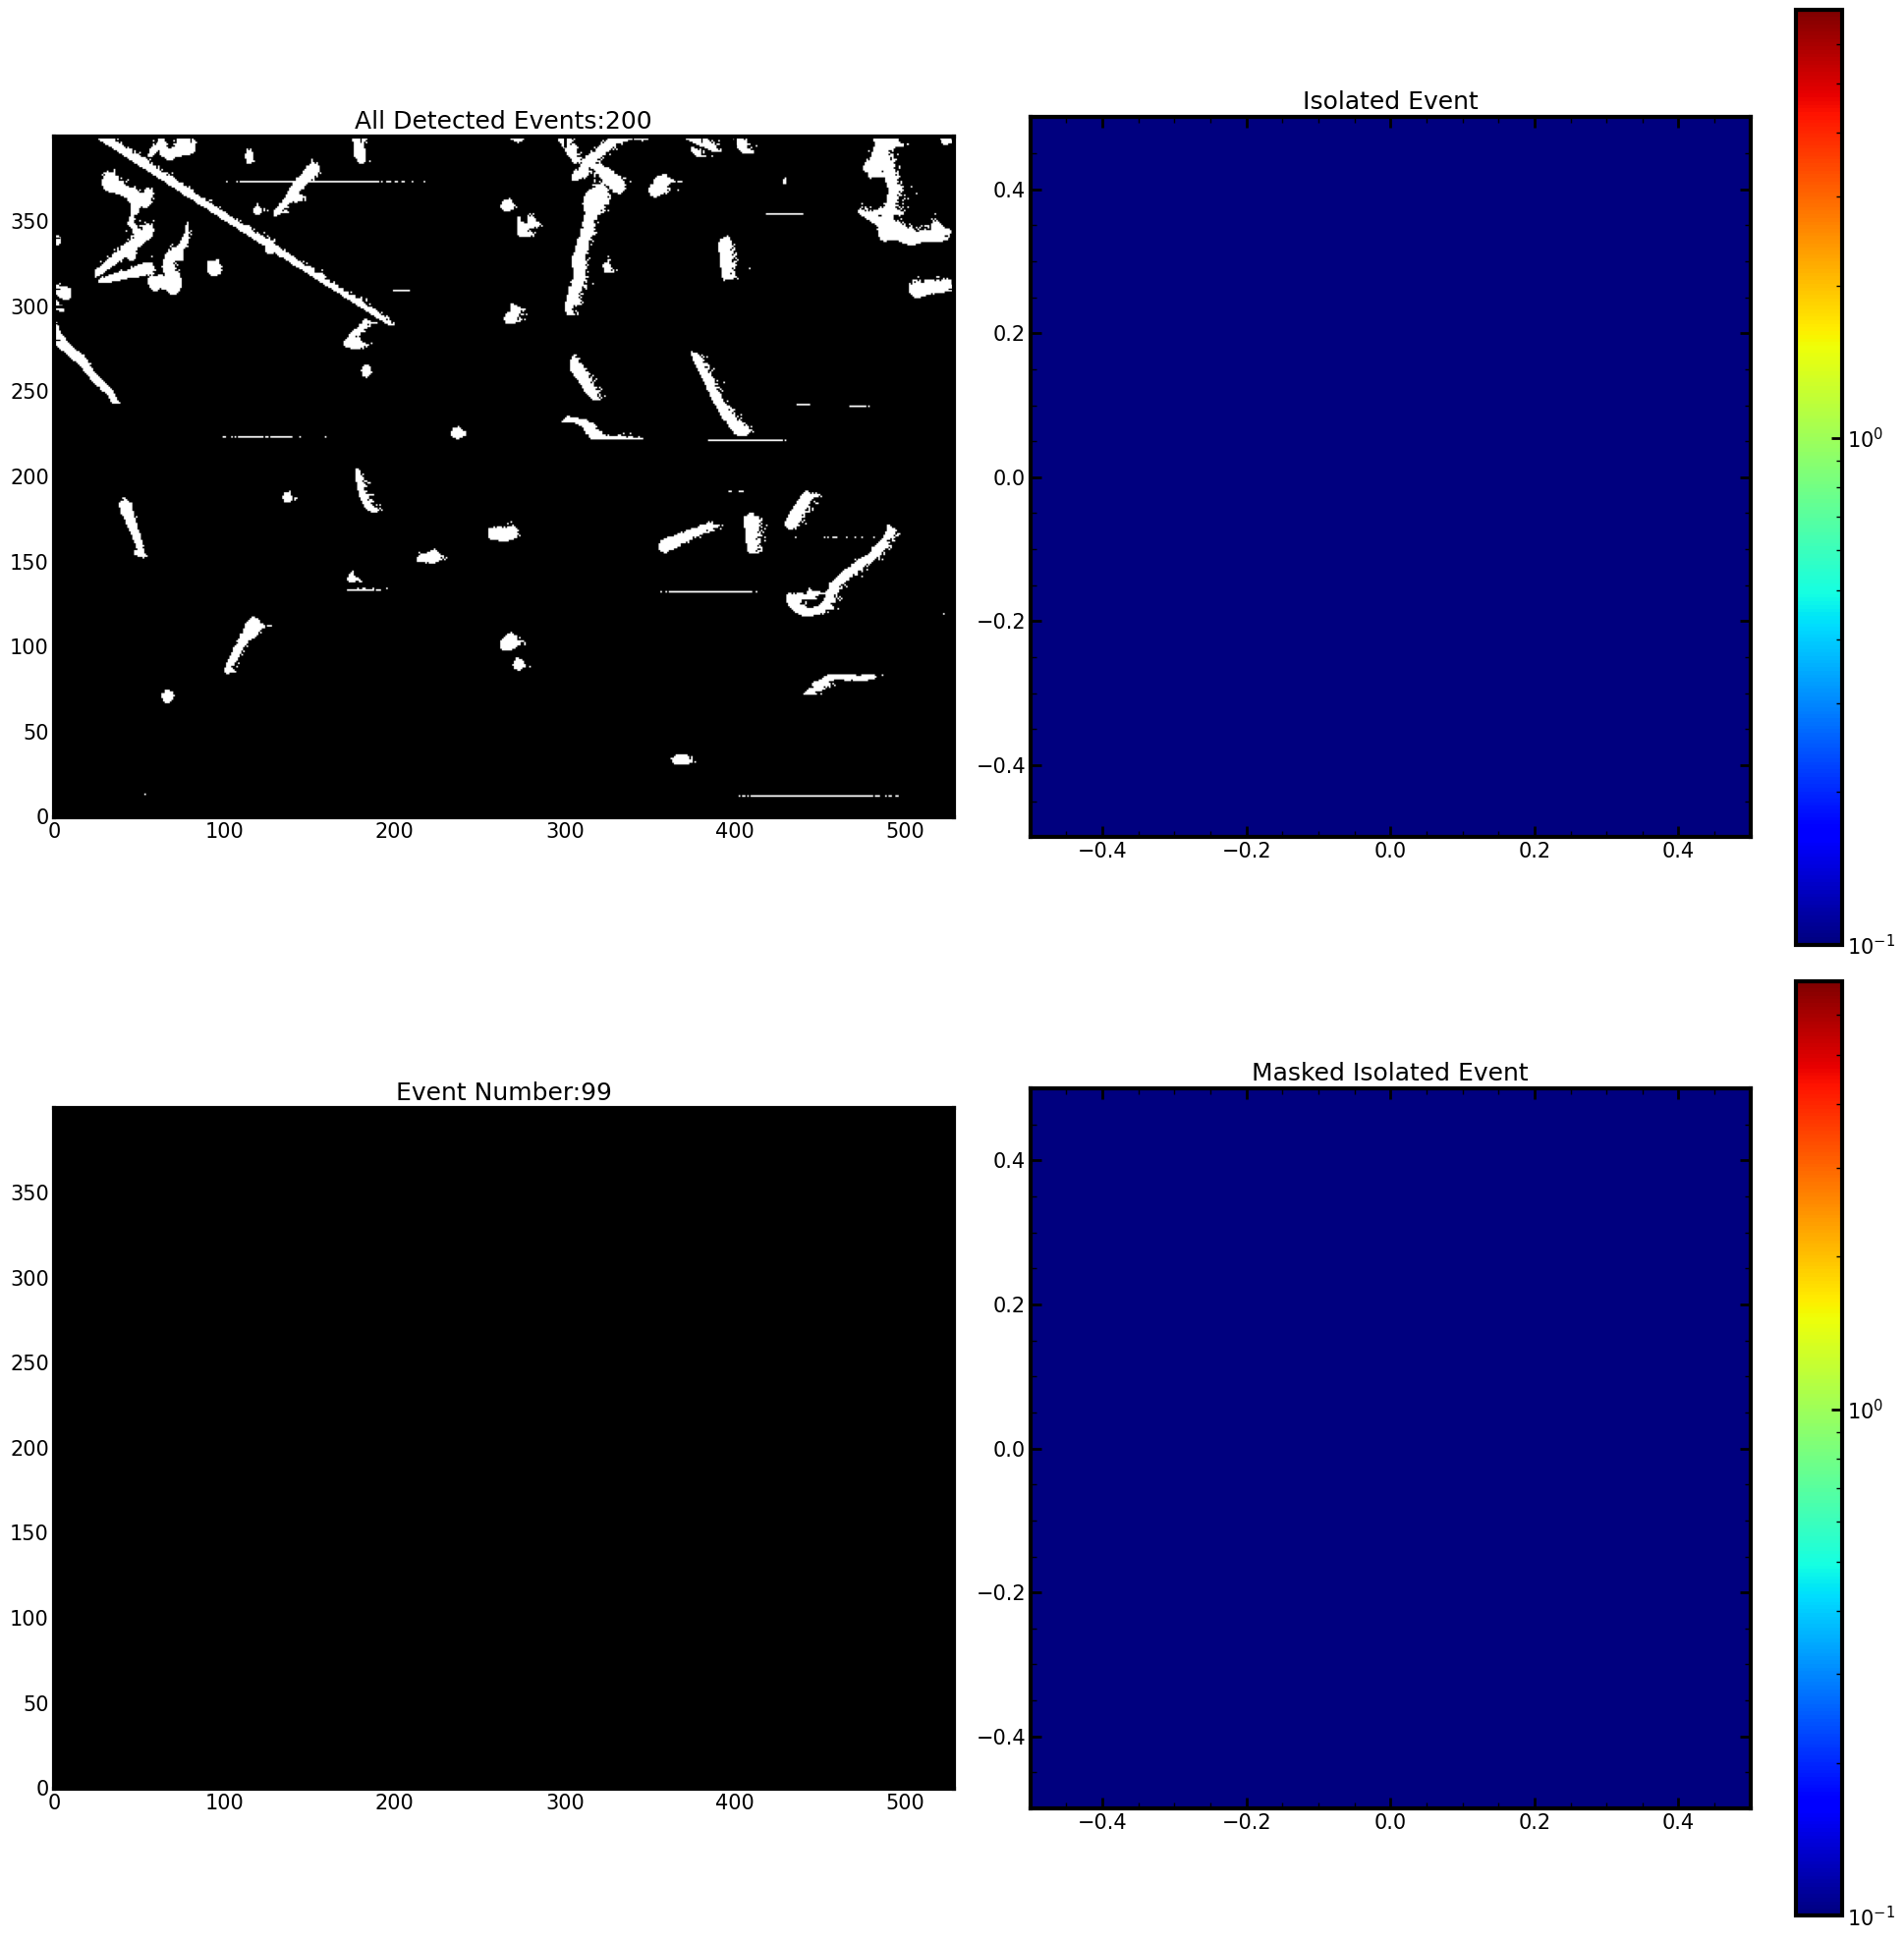

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
99,101,2,1x1,1,0.016443,0.016,"[0.0, 0.0]"


In [223]:
n_label = 99
extra = 0


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[20,20])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap, norm = Norm)#, origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap, norm = Norm)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.tight_layout()
plt.show()


TotalDataFrame.iloc[[n_label-1]]

### Con faldas

6
Event Slice:
x: [44,46]
y: [96,97]


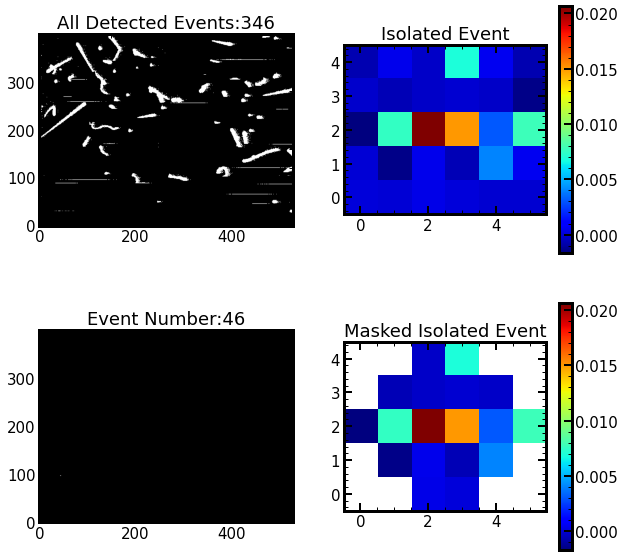

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
46,100,1,2x1,2,0.0357,0.018,"[0.5, 0.0]"


In [19]:
n_label = 46
n_skirts = 2
extra = 2


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[10,10])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap)#, origin = 'lower')
# plt.colorbar()

### Skirts ###
mask_35 = np.invert(nd.binary_dilation(label==n_label, iterations= n_skirts))
# mask_35 = np.invert(label==n_label)
# skirt = nd.binary_dilation(mask_35, structure=[[0,0,0],[0,1,0],[0,0,0]], iterations = 2)
# print(skirt)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()


TotalDataFrame.iloc[[n_label-1]]

## Pruebas de la paquetería Sckit-Image

Centroide:  (np.float64(191.0), np.float64(396.5))
Radio mayor:  2.0
Radio menor:  0.0
Box:  (191, 396, 192, 398)
Centroide Local:  [0.  0.5]
Centroid Weighted:  (np.float64(191.0), np.float64(396.53435673563104))
Moments Hu:  [0.125    0.015625 0.       0.       0.       0.       0.      ]
Area_Convex:  2.0
Label:  70
Orientation:  1.5707963267948966
Slice:  (slice(191, 192, None), slice(396, 398, None))
Eccentricity:  1.0
Solidity:  1.0
Barycenter:  [0.  0.5]
Inertia tensor:  [[ 0.25 -0.  ]
 [-0.    0.  ]]
Intensity Max:  0.01616849936544895


Event Charge:  0.030257875  keV
Local Box:  [2, 1]  px
Local Box:  [30, 15] micras
Diagonal Lenght:  0.8218544151266947  px
Diagonal Lenght:  12.32781622690042  micras
Delta_L:  725.0004658237674  px
Delta_L:  10875.006987356512  micras
Delta EL:  4.1734973322256096e-05  keV/px
Delta EL:  2.782331554817073e-06  keV/micras
Delta EL:  0.4173497332225609  keV/cm


(np.float64(395.0), np.float64(399.0), np.float64(190.0), np.float64(193.0))

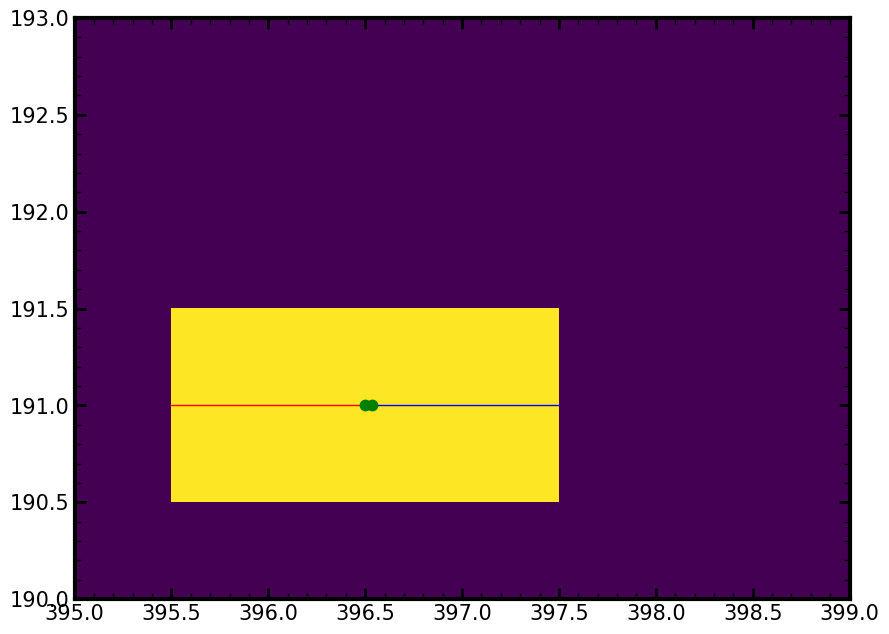

In [224]:
### Esta celda tiene el proceso para ir obteniendo las propiedadesd de un evento con la librería Scikit-Image

n_label= 70
CCD_depth = 725 ## micras
px_to_micras = 15 ## micras
px_to_cm = 0.0015 ## cm/px
micra_to_cm = 1 / 10000 ## micras/cm
fig, ax = plt.subplots(figsize=(10,10))

label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
# print(nlabels_img)
ax.imshow(label_img==n_label) # Matriz centrada en el origen

prop = sk.measure.regionprops(label_img,dataCal)
# prop = sk.measure.regionprops(label_img)


# loc = ndimage.find_objects(label==n_label)[0]
loc = prop[n_label-1].slice

mask_35 = np.invert(label_img==n_label)
# ax.imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
charge = data_mask.sum()
# plt.imshow(dataCal[maxim.start:maxim.stop])
# ax.imshow(data_mask)



print("Centroide: ", prop[n_label-1].centroid)
print("Radio mayor: ", prop[n_label-1].axis_major_length)
print("Radio menor: ", prop[n_label-1].axis_minor_length)
print("Box: ", prop[n_label-1].bbox)
print("Centroide Local: ", prop[n_label-1].centroid_local)
print('Centroid Weighted: ', prop[n_label-1].centroid_weighted)
# print(prop[n_label-1].centroid_weighted_local)
# print(prop[n_label-1].coords_scaled)
# print(prop[n_label-1].coords)
# print(prop[n_label-1].extent)
# print(prop[n_label-1].image)
# print(prop[n_label-1].image_intensity)
# print('Moments: ', prop[n_label-1].moments)
# print('Moments Central: ', prop[n_label-1].moments_central)
print('Moments Hu: ', prop[n_label-1].moments_hu)
print('Area_Convex: ', prop[n_label-1].area_convex)
print('Label: ', prop[n_label-1].label)
print('Orientation: ', prop[n_label-1].orientation)
print('Slice: ', prop[n_label-1].slice)
print('Eccentricity: ', prop[n_label-1].eccentricity)
print('Solidity: ', prop[n_label-1].solidity)
print('Barycenter: ', prop[n_label-1].centroid_local)
print('Inertia tensor: ', prop[n_label-1].inertia_tensor)
print('Intensity Max: ', prop[n_label-1].intensity_max)

## Box and Delta_L
miny, minx, maxy, maxx = prop[n_label-1].bbox
Longitud_y = maxy - miny # px
Longitud_x = maxx - minx # px
Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
Delta_L = np.sqrt(Diagonal_lenght**2 + CCD_depth**2) # px
DeltaEL = charge / Delta_L # keV/px

print('\n')

# new_par = np.sqrt(prop[n_label-1].inertia_tensor[0][0]**2 + prop[n_label-1].inertia_tensor[1][1]**2)/Diagonal_lenght
# print("New Par: ", new_par)
## Ellipse 
y0, x0 = prop[n_label-1].centroid
# y0, x0 = prop[n_label-1].centroid_weighted

orientation = prop[n_label-1].orientation
rotation = orientation*1
x1 = x0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_minor_length

x2 = x0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio

x3 = x0 - math.sin(-orientation) * 0.5 * prop[n_label-1].axis_major_length
y3 = y0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio


ax.plot((x0, x1), (y0, y1), 'r', linewidth=1)
ax.plot((x0, x3), (y0, y3), 'b', linewidth=1)
ax.plot((x0, x2), (y0, y2), 'r', linewidth=1)

ax.plot(x0, y0, '.g', markersize=15) # Ellipse's center
ax.plot(prop[n_label-1].centroid_weighted[1], prop[n_label-1].centroid_weighted[0], '.g', markersize=15)


print('Event Charge: ', charge, ' keV')
print("Local Box: ", [Longitud_x, Longitud_y], ' px' )
print("Local Box: ", [Longitud_x * px_to_micras, Longitud_y * px_to_micras], 'micras' )
print('Diagonal Lenght: ', Diagonal_lenght, ' px') ## px
print('Diagonal Lenght: ', Diagonal_lenght * px_to_micras, ' micras')
print('Delta_L: ', Delta_L, ' px')
print('Delta_L: ', Delta_L * px_to_micras, ' micras')
print('Delta EL: ', DeltaEL, ' keV/px')
print('Delta EL: ', DeltaEL / px_to_micras, ' keV/micras')
print('Delta EL: ', DeltaEL / micra_to_cm, ' keV/cm')
bx = (minx, maxx, maxx, minx, minx)
by = (miny, miny, maxy, maxy, miny)
# ax.plot(bx, by, '-b', linewidth=2.5)


# excent = prop[n_label-1].eccentricity
u= x0   #x-position of the center
v= y0    #y-position of the center
b = prop[n_label-1].axis_major_length    #radius on the x-axis
a = prop[n_label-1].axis_minor_length   #radius on the y-axis

ext=1
ax.axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))
# ax.imshow(data_mask)
# ax.can_zoom()

## Filtro de muones 

In [225]:
## Calcula cuantos eventos rectos tiene la extensión comparando la relación del radio mayor de la elipse con el radio menor
dict_lists = muon_filter(dataCal=dataCal, label_img=label_img, nlabels_img=nlabels_img, prop=prop, Solidit=0.65, Elipticity=0.65, dedl_min = 1500)
DeltaL = dict_lists["muons"]["l"]
DeltaEL = dict_lists["muons"]["dedl"]
list_charge = dict_lists["muons"]["charge_muons"]
list_theta = dict_lists["muons"]["theta"]
list_phi = dict_lists["muons"]["phi"]
list_elip = dict_lists["muons"]["elip"]
list_soli = dict_lists["muons"]["sol"]
list_datamasked = dict_lists["muons"]["image"]
lebel_muons = dict_lists["muons"]["label"]

list_charge_all_events = dict_lists["non_muons"]["charge"]
list_elip_all = dict_lists["non_muons"]["elip"]
list_sol_all = dict_lists["non_muons"]["sol"]
                                                                    
print('All Clusters: ', nlabels_img)
print('Muons Detected: ', len(lebel_muons))
print(lebel_muons)
Straight_Events = lebel_muons


DF_straightevents = pd.DataFrame(lebel_muons, columns=['Event ID'] )
DF_dl = pd.DataFrame(DeltaL, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (KeV)'])
DF_dedl = pd.DataFrame(DeltaEL, columns=['dE/dL (KeV/cm)'])
DF_thet = pd.DataFrame(list_theta, columns=['Theta (Rad)'])
DF_phi = pd.DataFrame(list_phi, columns=['Phi (Rad)'])
DF_elip = pd.DataFrame(list_elip, columns=['Elipticity'])
DF_soli = pd.DataFrame(list_soli, columns=['Solidity'])
DF_dEdL = pd.concat([DF_straightevents, DF_dl, DF_charge,  DF_dedl, DF_thet, DF_phi, DF_elip, DF_soli], axis=1)
DF_dEdL.set_index('Event ID')

All Clusters:  200
Muons Detected:  4
[41, 42, 94, 113]


,Delta L (cm),Charge (KeV),dE/dL (KeV/cm),Theta (Rad),Phi (Rad),Elipticity,Solidity
Event ID,,,,,,,
41,0.092594,288.539368,3116.179845,0.671340,1.842631,0.829003,0.704467
42,0.093434,209.476959,2241.973421,0.682581,3.553734,0.813023,0.783972
94,0.086621,211.063675,2436.642905,0.579051,5.213992,0.718789,0.765152
113,0.083887,201.977768,2407.746825,0.527116,3.255799,0.657490,0.861111


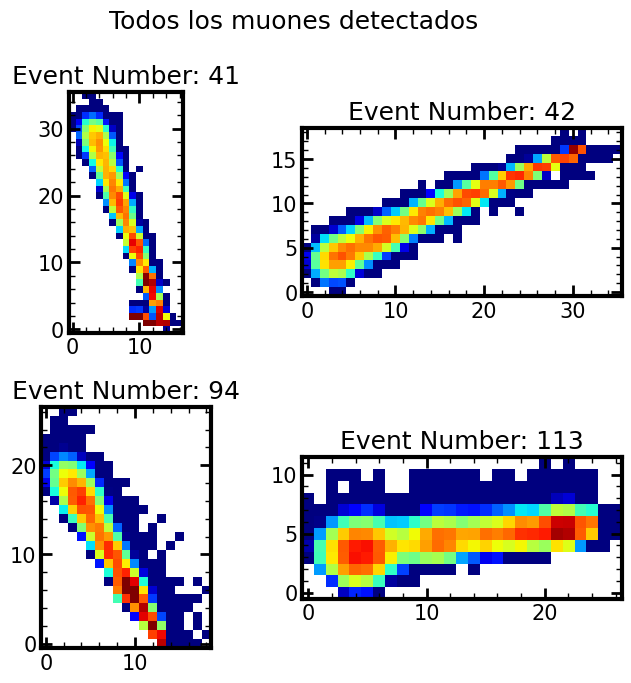

In [226]:
## Visualizar en una matriz los eventos rectos detectados 
coord2x2 = [[0,0],[0,1], [1,0], [1,1]]

coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

coord4x4 = [[0,0],[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3], [2,0], [2,1], [2,2], [2,3], [3,0], [3,1], [3,2], [3,3]]

coords5x5 = [[0,0],[0,1], [0,2], [0,3], [0,4], [1,0], [1,1], [1,2], [1,3], [1,4], [2,0], [2,1], [2,2], [2,3], [2,4], [3,0], [3,1], [3,2], [3,3], [3,4],[4,0], [4,1], [4,2], [4,3], [4,4]]

if len(Straight_Events) < 5:
    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(7,7))
    fig.suptitle('Todos los muones detectados')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord2x2[index_event][0],coord2x2[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(data_mask, cmap = Colormap, norm = Norm) ## Event with mask
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_


elif len(Straight_Events) > 4 and len(Straight_Events) < 10:
    fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(15,15))#, facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('Todos los muones detectados')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord3x3[index_event][0],coord3x3[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(data_mask, aspect = 1,  cmap= Colormap, norm = Norm) ## Event with mask
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_event, 7][1], 'ro') ## Plot the baricentrum

elif len(Straight_Events) > 9 and len(Straight_Events) < 17:
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(15,15))#, facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('Todos los muones detectados')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        # Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

        axs[coord4x4[index_event][0],coord4x4[index_event][1]].set_title('Número de evento: '+ str(Straight_Events[index_event]))
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(data_mask, aspect = 1, cmap = Colormap, norm = Norm) ## Event with mask
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].text(1,0,'dE/dx', transform = axs[coord4x4[index_event][0],coord4x4[index_event][1]].transAxes)

elif len(Straight_Events) > 16 and len(Straight_Events) <= 25:
    fig, axs = plt.subplots(ncols = 5, nrows = 5, figsize=(15,15))#, facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('Todos los muones detectados')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)        

        axs[coords5x5[index_event][0],coords5x5[index_event][1]].set_title('Número de evento: '+ str(Straight_Events[index_event]))
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(label_img == Straight_Events[index_event])
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(data_mask, aspect = 1, cmap = Colormap, norm = Norm) ## Event with mask

elif len(Straight_Events) > 25:
    print('Demasiados eventos para mostrar!!!')

plt.tight_layout()



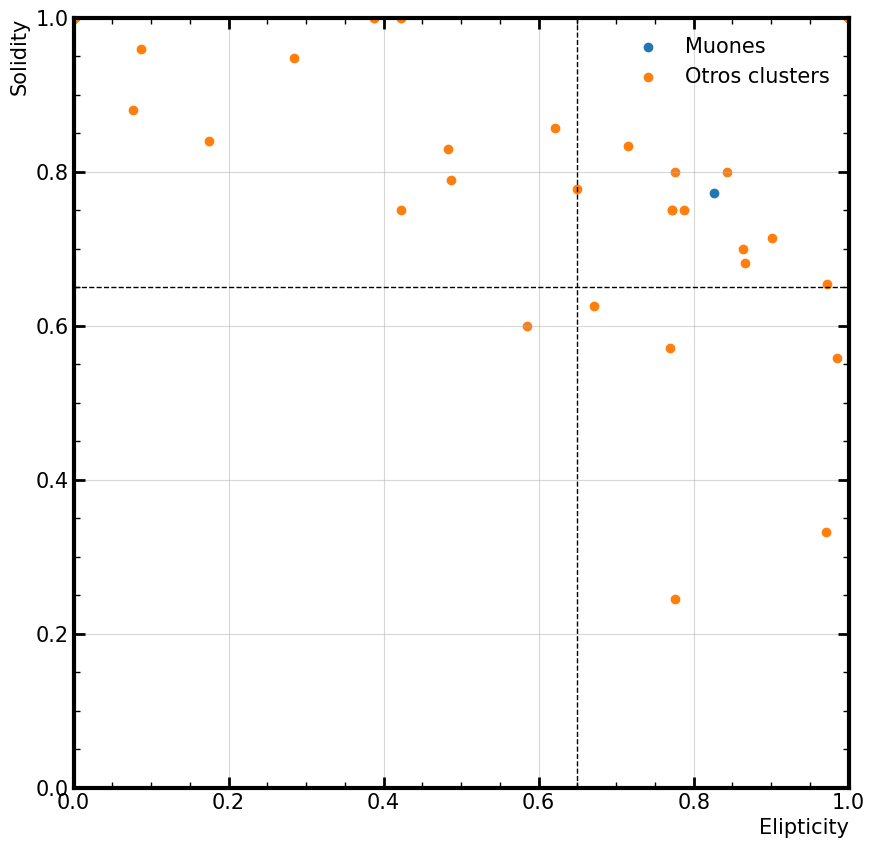

In [31]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10,10))
axs.scatter(list_elip, list_soli, label = 'Muones')
axs.scatter(list_elip_all, list_sol_all, label = 'Otros clusters')
axs.set_ylabel("Solidity")
axs.set_xlabel("Elipticity")

axs.vlines(0.65, 0, 1, colors="k", linestyles="dashed")
axs.hlines(0.65, 0, 1, colors="k", linestyles="dashed")

axs.set_ylim(0, 1)
axs.set_xlim(0, 1)
axs.legend()
axs.grid()
plt.show()

## Medición el ángulo phi

### Posición del píxel

In [ ]:
def chi2Function(par):
      # minimisation function computing the sum of squares of residuals
      # looping at the graph points
      # data_mask = par[0]
      NBX = data_mask.shape[1]
      NBY = data_mask.shape[0]
      # np = NBX * NBY
      chi2 = 0.0
      Qs = 0
      npix = 0

      for xbin in np.arange(0, NBX):
         for ybin in np.arange(0, NBY):
            q = data_mask[ybin][xbin]
            if q != 0:
               npix += 1
               Qs += q
               fxbin = par[0] + par[1] * xbin
               delt2 = (ybin - fxbin)**2 * q ## Este es el método que utiliza ROOT (KeV px^2)
               # delt2 = (ybin - fxbin)**2 * q**2 ## 
               chi2 += delt2

            else: 
                continue
            
      return chi2/Qs

# new_par = 0
def NumericalMinimization(minName = "GSLMultiMin", algoName = "BFGS2" ) :

   # create minimizer giving a name and a name (optionally) for the specific algorithm
  
   minimum = ROOT.Math.Factory.CreateMinimizer(minName, algoName)
   if (not minimum) :
      print("Error: cannot create minimizer",minName,"Maybe the required library was not built?")
      return 1

   # set tolerance , etc...
   minimum.SetMaxFunctionCalls(1000000) # for Minuit/Minuit2
   minimum.SetMaxIterations(10000)  # for GSL
   minimum.SetTolerance(0.00001)
   minimum.SetPrintLevel(1)

   # #create function wrapper for minimizer a IMultiGenFunction type
   f = ROOT.Math.Functor(chi2Function,2)
   step = [0.001,0.001]

   # # starting point
   variable = [0.51,0.76]

   minimum.SetFunction(f)

   # # Set the free variables to be minimized !
   minimum.SetVariable(0, "b", variable[0], step[0])
   minimum.SetVariable(1, "m", variable[1], step[1])

   # # do the minimization
   minimum.Minimize()

   xs = minimum.X()
   new_par = xs
   print( "Minimum: f(",xs[0], ",", xs[1] , "): ", minimum.MinValue() ) 
   print("Covmatrix : ",minimum.CovMatrix(0,0),minimum.CovMatrix(0,1))
   print("            ",minimum.CovMatrix(1,0),minimum.CovMatrix(1,1))
   
   return xs[0], xs[1], minimum.MinValue()
   # return 0

   

In [199]:
HOLA = 3

# ! export HOLA='30'


### Así se accede a las variables del enviroment
# os.environ

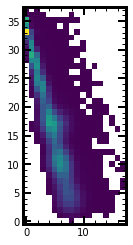

Shape of image (X, Y):  18 38
Ordenada:  33.147871979779545
Pendiente:  -3.095757971301989
Probabilidad:  0.0
Chi square ROOT:  8808.99205809741


Minimum: f( 31.099992993902262 , -3.095757972460394 ):  18.42739880050905
Covmatrix :  0.0 0.0
             0.0 0.0

pendiente negativa
El muon está en el sector 4
El ángulo phi es:  3.4540350854886146  rad o 197.90163268860613°
Minimize using GSLMinimizer vector_bfgs2
GSLMinimizer: Minimum Found
FVAL         = 18.4273988005090494
Niterations  = 4
NCalls     = 13
b	  = 31.1
m	  = -3.09576


Warning in <TCanvas::Constructor>: Deleting canvas with same name: C1


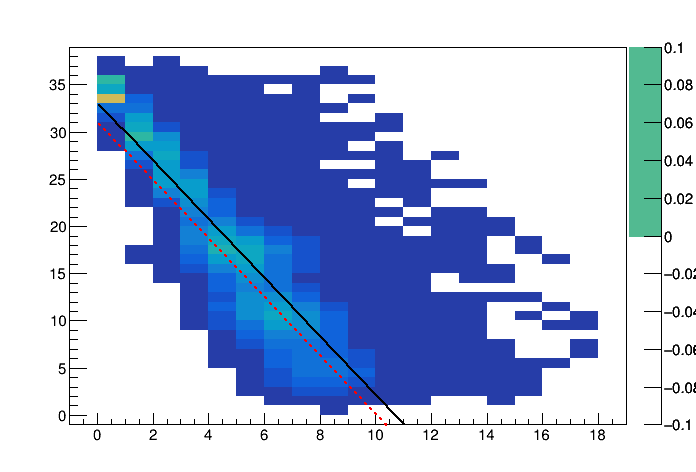

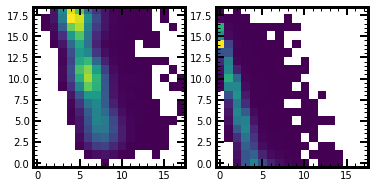

In [208]:
index_event = -1
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
plt.show()

# print(data_mask)

NBX = data_mask.shape[1]
xmin = 0
xmax = NBX
# print(NBX, len(data_mask[:, 1]))

NBY = data_mask.shape[0]
ymin = 0
ymax = NBY
# print(NBY, len(data_mask[1, :]))
print('Shape of image (X, Y): ', NBX, NBY)

def chi2Function(par):
      # minimisation function computing the sum of squares of residuals
      # looping at the graph points
      # data_mask = par[0]
      NBX = data_mask.shape[1]
      NBY = data_mask.shape[0]
      # np = NBX * NBY
      chi2 = 0.0
      Qs = 0
      npix = 0

      for xbin in np.arange(0, NBX):
         for ybin in np.arange(0, NBY):
            q = data_mask[ybin][xbin]
            if q != 0:
               npix += 1
               Qs += q
               fxbin = par[0] + par[1] * xbin
               delt2 = (ybin - fxbin)**2 * q ## Este es el método que utiliza ROOT (KeV px^2)
               # delt2 = (ybin - fxbin)**2 * q**2 ## 
               chi2 += delt2

            else: 
                continue
            
      return chi2/Qs

flag_ver = False
flag_hor = False
flag_obl = False

if NBX > NBY * 2:
    flag_hor = True
elif NBY > NBX * 2:
    flag_ver = True
else:
    flag_obl = True

Diagonal_lenght= np.sqrt(NBX**2 + NBY**2) - np.sqrt(2) # px
Delta_L = np.sqrt( (Diagonal_lenght)**2 + (CCD_depth)**2)  # px
charge = data_mask.sum()


canv = TCanvas("C1")

### ============== Hist Muon =============== ####
nbx = NBX
lox = 0
hix = data_mask.shape[1]

nby = NBY
loy = 0
hiy = data_mask.shape[0]

hist2d = TH2F("hist2d", "", nbx,lox,hix, nby,loy,hiy)
hist2d.SetStats(False)
# hist2d.Sumw2()

for i in np.arange(0, nbx):
    for j in np.arange(0, nby):
        # cont = data_mask[i][j]
        if data_mask[j][i]:
            hist2d.SetBinContent(int(i+1),int(j+1), data_mask[j][i])
        else:
            # n = n+1
            # print(n)
            cont = 0
            hist2d.SetBinContent(int(i+1),int(j+1), cont)

### ======================================== ###


frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
frame.AddDirectory(False)
frame.SetStats(0)

lox = 0
hix = NBX
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetLineColor(1)

# fitline.SetParameters(NBY-1, -pend)
hist2d.Fit("fitline", "RQ")  #### Funcionó aunque los paŕametros iniciales fueron malos

ordenada = fitline.GetParameters()[0]
pendiente = fitline.GetParameters()[1]
Prob = fitline.GetProb()
Chi2 = fitline.GetChisquare()

print('Ordenada: ', ordenada)
print('Pendiente: ', pendiente)
print('Probabilidad: ', Prob)
print("Chi square ROOT: ", 1 * Chi2, end= '\n\n')



def NumericalMinimization(minName = "GSLMultiMin", algoName = "BFGS2" ) :

   # create minimizer giving a name and a name (optionally) for the specific algorithm
  
   minimum = ROOT.Math.Factory.CreateMinimizer(minName, algoName)
   if (not minimum) :
      print("Error: cannot create minimizer",minName,"Maybe the required library was not built?")
      return 1

   # set tolerance , etc...
   minimum.SetMaxFunctionCalls(1000000) # for Minuit/Minuit2
   minimum.SetMaxIterations(10000)  # for GSL
   minimum.SetTolerance(0.00001)
   minimum.SetPrintLevel(1)

   # #create function wrapper for minimizer a IMultiGenFunction type
   f = ROOT.Math.Functor(chi2Function,2)
   step = [0.001,0.001]

   # # starting point
   variable = [ordenada, pendiente]

   minimum.SetFunction(f)

   # # Set the free variables to be minimized !
   minimum.SetVariable(0, "b", variable[0], step[0])
   minimum.SetVariable(1, "m", variable[1], step[1])

   # # do the minimization
   minimum.Minimize()

   xs = minimum.X()
   print( "Minimum: f(",xs[0], ",", xs[1] , "): ", minimum.MinValue() ) 
   print("Covmatrix : ",minimum.CovMatrix(0,0),minimum.CovMatrix(0,1))
   print("            ",minimum.CovMatrix(1,0),minimum.CovMatrix(1,1))
   
   return xs[0], xs[1], minimum.MinValue()
   # return 0


### === Modalidad del functor === ###
print("===========================", end='\n\n')
new_par = NumericalMinimization()

print("===========================", end='\n\n')


frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
canv.Draw()
frame.Draw()
frame.SetStats(0)
hist2d.Draw("samecolz")

fitline.Draw("same")
fitline.SetParameters(new_par[0], new_par[1])
fitline.SetLineColor(2)
fitline.SetLineWidth(2)
fitline.SetLineStyle(2)
fitline.Draw("same")

flag_hor = False
flag_ver = False

### ====== Determinación de si el muon es horizontal, vertical u oblicuo ====== ###
if NBX > NBY * 2:
    fig, axs = plt.subplots(1, 2)

    flag_hor = True
    c_l = data_mask[:, 0:int(NBX/2)]
    c_r = data_mask[:, int(NBX/2):NBX]

    axs[0].imshow(c_l)
    axs[1].imshow(c_r)  

elif NBY > NBX * 2:
    fig, axs = plt.subplots(1, 2)
    
    flag_ver = True
    c_d = data_mask[:int(NBY/2), :]
    c_u = data_mask[int(NBY/2):NBY, :]

    axs[0].imshow(c_d)
    axs[1].imshow(c_u) 
     
else: 
    fig, axs = plt.subplots(2, 2)

    c_ld = data_mask[0:int(NBY/2), 0:int(NBX/2)]
    c_lu = data_mask[int(NBY/2):NBY, 0:int(NBX/2)]
    c_rd = data_mask[0:int(NBY/2),int(NBX/2):NBX]
    c_ru = data_mask[int(NBY/2):NBY, int(NBX/2):NBX]

    axs[0,0].imshow(c_lu)
    axs[0,1].imshow(c_ru)
    axs[1,0].imshow(c_ld)
    axs[1,1].imshow(c_rd)
### =========================================================================== ###


if flag_hor: ## Es un muon horizontal
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva, muon horizontal')

        n_cl = 0
        n_cr = 0
        for index_y in np.arange(0, len(c_l)):
            # print(index)
            for index_x in np.arange(0, len(c_l[0])):
                # print(index_x)
                if c_l[index_y][index_x] != 0:
                    n_cl = n_cl +1

        for index_y in np.arange(0, len(c_r)):
            # print(index)
            for index_x in np.arange(0, len(c_r[0])):
                # print(index_x)
                if c_r[index_y][index_x] != 0:
                    n_cr = n_cr +1
        print(n_cl, n_cr)

        if n_cr > n_cl:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cr > n_cl:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa, muon horizontal')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cl = 0
        n_cr = 0
        for index_y in np.arange(0, len(c_l)):
            # print(index)
            for index_x in np.arange(0, len(c_l[0])):
                # print(index_x)
                if c_l[index_y][index_x] != 0:
                    n_cl = n_cl +1

        for index_y in np.arange(0, len(c_r)):
            # print(index)
            for index_x in np.arange(0, len(c_r[0])):
                # print(index_x)
                if c_r[index_y][index_x] != 0:
                    n_cr = n_cr +1

        if n_cr < n_cl:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi/2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cr > n_cl:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

if flag_ver: ## Es un muon horizontal
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva')

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_d)):
            # print(index)
            for index_x in np.arange(0, len(c_d[0])):
                # print(index_x)
                if c_d[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        for index_y in np.arange(0, len(c_u)):
            # print(index)
            for index_x in np.arange(0, len(c_u[0])):
                # print(index_x)
                if c_u[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        if n_cu > n_cd:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cu < n_cd:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_u)):
            # print(index)
            for index_x in np.arange(0, len(c_u[0])):
                # print(index_x)
                if c_u[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        for index_y in np.arange(0, len(c_d)):
            # print(index)
            for index_x in np.arange(0, len(c_d[0])):
                # print(index_x)
                if c_d[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        if n_cu > n_cd:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi/2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cu < n_cd:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')


if not flag_ver and not flag_hor: ## Otros casos
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva')

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_ld)):
            # print(index)
            for index_x in np.arange(0, len(c_ld[0])):
                # print(index_x)
                if c_ld[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        for index_y in np.arange(0, len(c_ru)):
            # print(index)
            for index_x in np.arange(0, len(c_ru[0])):
                # print(index_x)
                if c_ru[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        if n_cu > n_cd:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cu < n_cd:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_lu)):
            # print(index)
            for index_x in np.arange(0, len(c_lu[0])):
                # print(index_x)
                if c_lu[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        for index_y in np.arange(0, len(c_rd)):
            # print(index)
            for index_x in np.arange(0, len(c_rd[0])):
                # print(index_x)
                if c_rd[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        if n_cu > n_cd:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi/2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cu < n_cd:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
      

In [141]:
npix = 0
for xbin in np.arange(0, NBX):
    for ybin in np.arange(0, NBY):
        q = data_mask[ybin][xbin]
        if q != 0:
            # print(q)
            npix += 1
print('Npix: ', npix)

Npix:  249


In [41]:
if flag_hor: ## Es un muon horizontal
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva')

        n_cl = 0
        n_cr = 0
        for index_y in np.arange(0, len(c_l)):
            # print(index)
            for index_x in np.arange(0, len(c_l[0])):
                # print(index_x)
                if c_l[index_y][index_x] != 0:
                    n_cl = n_cl +1

        for index_y in np.arange(0, len(c_r)):
            # print(index)
            for index_x in np.arange(0, len(c_r[0])):
                # print(index_x)
                if c_r[index_y][index_x] != 0:
                    n_cr = n_cr +1

        if n_cl > n_cr:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cr > n_cl:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cl = 0
        n_cr = 0
        for index_y in np.arange(0, len(c_l)):
            # print(index)
            for index_x in np.arange(0, len(c_l[0])):
                # print(index_x)
                if c_l[index_y][index_x] != 0:
                    n_cl = n_cl +1

        for index_y in np.arange(0, len(c_r)):
            # print(index)
            for index_x in np.arange(0, len(c_r[0])):
                # print(index_x)
                if c_r[index_y][index_x] != 0:
                    n_cr = n_cr +1

        if n_cl > n_cr:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cr > n_cl:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

if flag_ver: ## Es un muon horizontal
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva')

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_d)):
            # print(index)
            for index_x in np.arange(0, len(c_d[0])):
                # print(index_x)
                if c_d[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        for index_y in np.arange(0, len(c_u)):
            # print(index)
            for index_x in np.arange(0, len(c_u[0])):
                # print(index_x)
                if c_u[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        if n_cu > n_cd:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cd > n_cu:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_u)):
            # print(index)
            for index_x in np.arange(0, len(c_u[0])):
                # print(index_x)
                if c_u[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        for index_y in np.arange(0, len(c_d)):
            # print(index)
            for index_x in np.arange(0, len(c_d[0])):
                # print(index_x)
                if c_d[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        if n_cu > n_cd:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cd > n_cu:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')


if not flag_ver and not flag_hor: ## Otros casos
    if pendiente > 0:
        ## El muon puede estar en el cuadrante 1 o 3
        print('pendiente positiva')

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_ld)):
            # print(index)
            for index_x in np.arange(0, len(c_ld[0])):
                # print(index_x)
                if c_ld[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        for index_y in np.arange(0, len(c_ru)):
            # print(index)
            for index_x in np.arange(0, len(c_ru[0])):
                # print(index_x)
                if c_ru[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        if n_cu > n_cd:
            print('El muon está en el sector 1')
            phi = np.arctan(pendiente)
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cd > n_cu:
            print('El muon está en el sector 3')
            phi = np.arctan(pendiente) + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: 
        print('pendiente negativa')
        ### El muon puede estar en el cuadrante 2 o 4

        n_cu = 0
        n_cd = 0
        for index_y in np.arange(0, len(c_lu)):
            # print(index)
            for index_x in np.arange(0, len(c_lu[0])):
                # print(index_x)
                if c_lu[index_y][index_x] != 0:
                    n_cu = n_cu + 1

        for index_y in np.arange(0, len(c_rd)):
            # print(index)
            for index_x in np.arange(0, len(c_rd[0])):
                # print(index_x)
                if c_rd[index_y][index_x] != 0:
                    n_cd = n_cd + 1

        if n_cu > n_cd:
            print('El muon está en el sector 2')
            phi = np.arctan(pendiente)  + np.pi
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')

        elif n_cd > n_cu:
            print('El muon está en el sector 4')
            phi = np.arctan(pendiente) + 3 * np.pi/ 2
            print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
        

pendiente positiva
El muon está en el sector 3
El ángulo phi es:  4.159670065548455  rad o 238.33153892283298°


### Renglones y columnas

La longitud del renglon es:  22
La longitud de la columna es:  27
El renglon de abajo tiene:  5  elementos no vacíos.
El renglon de arriba tiene:  2  elementos no vacíos.
La cola está arriba 

La columna de la izquierda tiene:  3  elementos no vacíos.
La columna de la derecha tiene:  6  elementos no vacíos.
La cola está a la izquierda


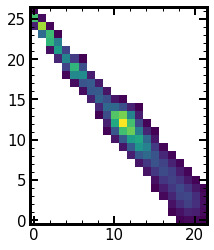

In [405]:
index_event = 3 # 6
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
# prop[event-1]
# print(data_mask.max)

len_y, len_x = data_mask.shape
flag_u, flag_d, flag_l, flag_r = False, False, False, False

n_up = 0
n_down = 0
row_down = data_mask[2]
row_up = data_mask[-2]

print('La longitud del renglon es: ', len_x)
print('La longitud de la columna es: ', len_y)
## Se cuentan los elementos que son distintos de cero
for element in row_up:
    if element != 0:
        n_up = n_up + 1
for element in row_down:
    if element != 0:
        n_down = n_down + 1

print('El renglon de abajo tiene: ', n_down, ' elementos no vacíos.')
print('El renglon de arriba tiene: ', n_up, ' elementos no vacíos.')
# print(len_x - n_up)
# print(len_x - n_down)
if n_down < n_up:
    flag_d = True
    print('La cola está abajo \n')
else:
    flag_u = True
    print('La cola está arriba \n')

n_left = 0
n_right = 0

col_left = data_mask[:,1]
col_right = data_mask[:,-2]
for element in col_left:
    if element != 0:
        n_left = n_left + 1
for element in col_right:
    if element != 0:
        n_right = n_right + 1
print('La columna de la izquierda tiene: ', n_left, ' elementos no vacíos.')
print('La columna de la derecha tiene: ', n_right, ' elementos no vacíos.')

# print(len_y - n_left)
# print(len_y - n_right)
if n_left < n_right:
    flag_l = True
    print('La cola está a la izquierda')
else: 
    flag_r = True
    print('La cola está a la derecha')


# print(len(data_mask[:,5]))
# print(data_mask[5])

In [406]:
# print(flag_u)
if len_x < 7:
    len_x = len_x / 2
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

elif len_y < 7:
    len_y = len_y / 2
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

else:
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

print('El ángulo phi del muon es: ', np.degrees(phi))

El ángulo phi del muon es:  309.1736579704442


### Con sigmas X y Y

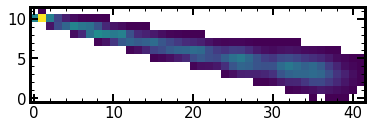

Shape of image (X, Y):  42 12
Len XProfile:  12
Len YProfile:  42


In [335]:
index_event = -1
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
plt.show()

# print(data_mask)

NBX = data_mask.shape[1]
xmin = 0
xmax = NBX
# print(NBX, len(data_mask[:, 1]))

NBY = data_mask.shape[0]
ymin = 0
ymax = NBY
# print(NBY, len(data_mask[1, :]))
print('Shape of image (X, Y): ', NBX, NBY)


YProf = TProfile("YProf", "", NBX, 0, xmax)
XProf = TProfile("XProf", "", NBY, 0, ymax)

for i in np.arange(0, NBX):
    # print(i)
    for j in np.arange(0, NBY):
        # print(j)
        if data_mask[j][i]:
            XProf.Fill(j, i, data_mask[j][i])
            YProf.Fill(i, j, data_mask[j][i])


list_yprofile_mean = []
list_yprofile_sigma = []
for index in np.arange(0, NBX):
    mean_y = YProf.GetBinContent(int(index+1))
    sigma_y = YProf.GetBinError(int(index+1))

    list_yprofile_mean.append(mean_y)
    list_yprofile_sigma.append(sigma_y)
# print(list_yprofile_sigma)

list_xprofile_mean = []
list_xprofile_sigma = []
for index in np.arange(0, NBY):
    mean_x = XProf.GetBinContent(int(index+1))
    sigma_x = XProf.GetBinError(int(index+1))

    list_xprofile_mean.append(mean_x)
    list_xprofile_sigma.append(sigma_x)

print('Len XProfile: ', len(list_xprofile_mean))
print('Len YProfile: ', len(list_yprofile_mean))
# print(list_yprofile_mean)



In [336]:
print('YMEAN: ', list_yprofile_mean)
print('YSIG: ', list_yprofile_sigma)
print('XSIG: ', list_xprofile_mean)
print('XMEAN: ', list_xprofile_sigma)

YMEAN:  [10.0, 10.007158841258349, 9.884743584048703, 9.467736954108494, 9.20762391921679, 8.995355342838009, 8.798264704734077, 8.516086267136963, 8.343023371104662, 8.119818339887788, 7.835414450339764, 7.679758450875391, 7.417371532331548, 7.2129339389436105, 7.005982637190096, 6.780027171771997, 6.586432722516005, 6.35588800304621, 6.195723784806192, 6.027599950902958, 5.80433164351338, 5.647114499378161, 5.503445983792224, 5.31680414498771, 5.036051528363731, 4.859282416156951, 4.715967394975661, 4.606446895042961, 4.4418655392447235, 4.266009425727166, 4.068107546346074, 3.9229524809485654, 3.8345628420887006, 3.7340905108431923, 3.4959088049647202, 3.351382830736962, 3.22789595204273, 3.0930995413565463, 2.9625262133223242, 2.815959479847962, 2.8325952558533185, 3.189102849279298]
YSIG:  [0.0, 0.08370517615401918, 0.28491339771484436, 0.3535503260318013, 0.33224245550396186, 0.32974410333531035, 0.36007176305194405, 0.36593256636345595, 0.3848334740293108, 0.4096170485306, 0.399

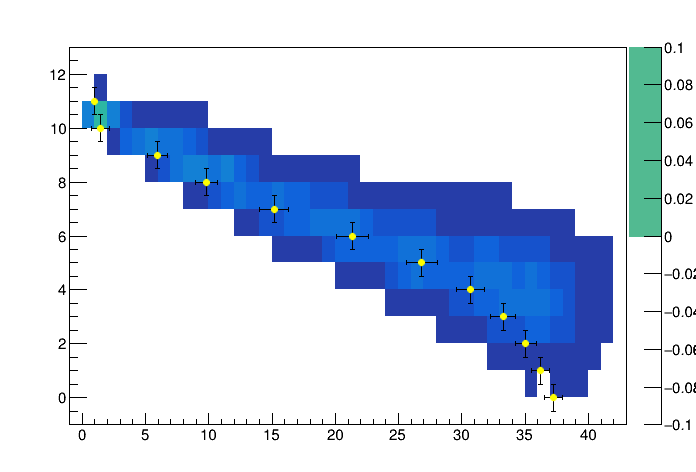

In [337]:
GRprofX = TGraphErrors()
GRprofY = TGraphErrors()

for i in np.arange(0, NBX):
    GRprofY.SetPoint(int(i), i, list_yprofile_mean[i])
    GRprofY.SetPointError(int(i), 1/2, list_yprofile_sigma[i])
    
for ip in np.arange(0, NBY):
    GRprofX.SetPoint(int(ip),  list_xprofile_mean[ip], ip)
    GRprofX.SetPointError(int(ip), list_xprofile_sigma[ip], 1/2)


canv = TCanvas("C1")
frame = TH2F("frame", "", 40,-1,NBX+1,40,-1,NBY+1)
frame.AddDirectory(False)
canv.Draw()
frame.Draw()

### -------------- Hist Muon ------------- ####
nbx = NBX
lox = 0
hix = data_mask.shape[1]

nby = NBY
loy = 0
hiy = data_mask.shape[0]

hist2d = TH2F("hist2d", "", nbx,lox,hix, nby,loy,hiy)
for i in np.arange(0, nbx):
    for j in np.arange(0, nby):
        # cont = data_mask[i][j]
        if data_mask[j][i]:
            hist2d.SetBinContent(int(i+1),int(j+1), data_mask[j][i])
        else:
            # n = n+1
            # print(n)
            cont = 0
            hist2d.SetBinContent(int(i+1),int(j+1), cont)

### ---------------------------------------- ###

frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)

canv.Draw()
frame.Draw()
frame.SetStats(0)
hist2d.Draw("samecolz")

GRprofX.SetMarkerStyle(20)
GRprofX.SetMarkerSize(0.8)
GRprofX.SetMarkerColor(5)
GRprofX.Draw("P same")

GRprofY.SetMarkerStyle(20)
GRprofY.SetMarkerSize(0.8)
GRprofY.SetMarkerColor(2)
# GRprofY.Draw("p same")

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7310682046711711, 0.7292583570608773, 0.8460826543722526, 1.001545322779878, 1.1001342708046093, 1.2140046379318103, 1.269584015684558, 1.1398630957148466, 0.8936022912596356, 0.7827081490349621, 0.7217973156005171, 0.0]


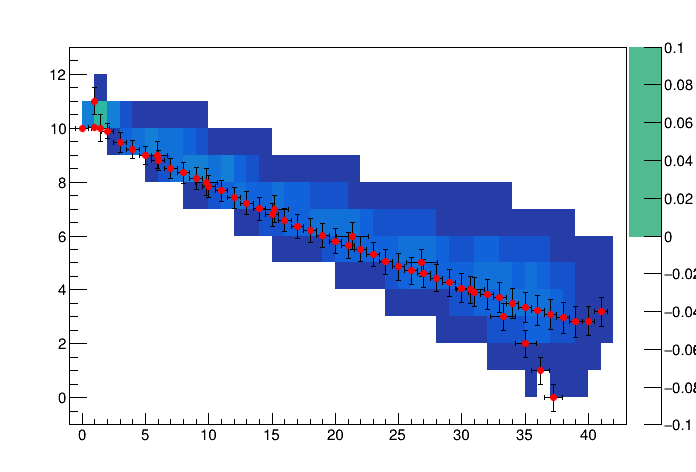

In [338]:
#### -------------------- MEAN XY ---------------- ###
list_x_XY = list(np.arange(0, NBX))
for element in list_xprofile_mean:
    list_x_XY.append(element)
# print(list_x_XY)

list_y_XY = list(list_yprofile_mean)
for element in np.arange(0, NBY):
    list_y_XY.append(element)
# print(list_y_XY)
### ----------------------------------------------- ###

#### -------------------- SIGMA XY ---------------- ###
zerosXY = list(np.zeros(NBX))
list_xsigma_XY = []
for index in np.arange(0, len(zerosXY)):
    list_xsigma_XY.append(1/2)
# print(list_xsigma_XY)

for element in list_xprofile_sigma:
    list_xsigma_XY.append(element)
print(list_xsigma_XY)

list_ysigma_XY = list(list_yprofile_sigma)
for element in list(np.zeros(NBY)):
    list_ysigma_XY.append(1/2)
# print(list_ysigma_XY)
### ----------------------------------------------- ###



# plt.plot(list_x, list_y, 'o')

GRprofXY = TGraphErrors()

for index in np.arange(0, len(list_y_XY)):
    GRprofXY.SetPoint(int(index), list_x_XY[index], list_y_XY[index])
    GRprofXY.SetPointError(int(index), list_xsigma_XY[index], list_ysigma_XY[index])

canv = TCanvas("c1")
frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
frame.AddDirectory(False)
canv.Draw()
frame.Draw()
frame.SetStats(0)

hist2d.Draw("samecolz")

GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.8)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")


Ordenada:  10.003455935340709
Pendiente:  -0.19476668406309072
Probabilidad:  0.9994739323771639
Chi square:  16.977082937033632
 FCN=16.9771 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=1.69788e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00035e+01   6.67955e-02   1.09122e-04   8.98224e-03
   2  p1          -1.94767e-01   4.31907e-03   7.05647e-06   1.63960e-01


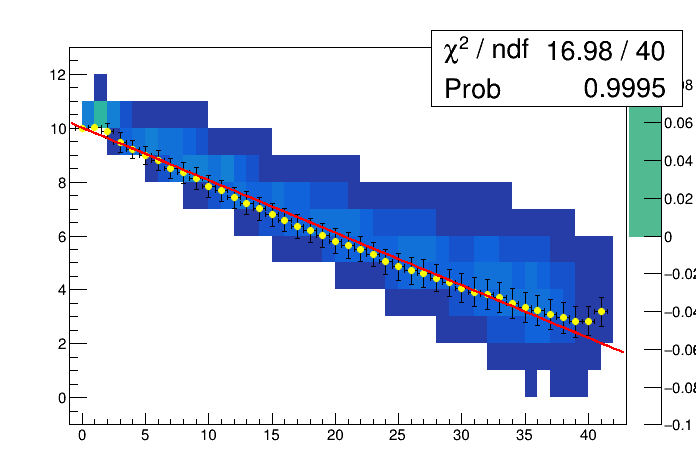

In [342]:
lox = 0
hix = NBX
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 

diag = np.sqrt(NBX**2 + NBY**2)
pend = NBY/NBX


fitline.SetParameters(NBY-1, -pend)
GRprofY.Fit("fitline") 
ordenada = fitline.GetParameters()[0]
pendiente = fitline.GetParameters()[1]
Prob = fitline.GetProb()

print('Ordenada: ', ordenada)
print('Pendiente: ', pendiente)
print('Probabilidad: ', Prob)
print("Chi square: ", fitline.GetChisquare())

if Prob < 0.05:
    print('El ajuste con pendiente negativa falló')
    fitline.SetParameters(0, pend)
    # fitline.SetParameters(1, 1)
    # GRprofY.Fit("fitline", "W")  #### Funcionó aunque los paŕametros iniciales fueron malos
    GRprofY.Fit("fitline")  
    # GRprofY.Fit("fitline", "C")

    ordenada = fitline.GetParameters()[0]
    pendiente = fitline.GetParameters()[1]
    Prob = fitline.GetProb()

    print('Ordenada: ', ordenada)
    print('Pendiente: ', pendiente)
    print('Probabilidad: ', Prob)
    print("Chi square: ", fitline.GetChisquare())

    if Prob < 0.05:
        print('Esto no es un muon')
    else:
        print('Esto si es un muon')

frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
canv.Draw()
frame.Draw()
frame.SetStats(0)
hist2d.Draw("samecolz")

# GRprofXY.SetMarkerStyle(20)
# GRprofXY.SetMarkerSize(0.8)
# GRprofXY.SetMarkerColor(5)
# GRprofXY.Draw("P same")

# GRprofX.SetMarkerStyle(20)
# GRprofX.SetMarkerSize(0.8)
# GRprofX.SetMarkerColor(5)
# GRprofX.Draw("P same")

GRprofY.SetMarkerStyle(20)
GRprofY.SetMarkerSize(0.8)
GRprofY.SetMarkerColor(5)
GRprofY.Draw("P same")

fitline.Draw("same")

In [218]:
First = list_yprofile_sigma[5]
Last = list_yprofile_sigma[-5]
print(First, Last)

if pendiente > 0:
    print('pendiente positiva')
    if First < Last: ## La "cola" está en la parte de abajo, y el muon está en el cuadrante 1
        phi = np.arctan(pendiente)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 3
        phi = np.arctan(pendiente) + np.radians(180)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
else: 
    print('pendiente negativa')
    if First < Last: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 4
        phi = np.arctan(pendiente) + np.radians(270)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 4
        phi = np.arctan(NBX/NBY) + np.radians(90)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    

0.27018795482257685 0.554374476472643
pendiente positiva
El ángulo phi es:  0.20090711042613066  rad o 11.511129501586066°


Muones detectados:  10
Shape (Y, X):  (23, 18)
El ángulo phi es: -3 o -171.88733853924697°


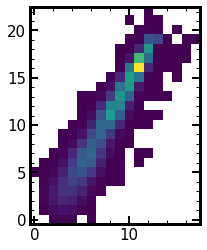


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      49.6988
NDf                       =           16
Edm                       =  5.98765e-21
NCalls                    =           31
p0                        =      1.90493   +/-   0.79735     
p1                        =      1.09892   +/-   0.0800693   

****************************************
Minimizer is Minuit / Migrad
Chi2                      =      49.6988
NDf                       =           16
Edm                       =  3.41975e-22
NCalls                    =           41
p0                        =      1.90493   +/-   0.79735     
p1                        =      1.09892   +/-   0.0800693   
 FCN=88.2933 FROM MIGRAD    STATUS=CONVERGED      38 CALLS          39 TOTAL
                     EDM=5.11356e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZ

In [96]:
print('Muones detectados: ', len(Straight_Events))
index_event = 1 # En la imagen 100 funcionó con todos con phi_angle_ROOT()
                 #
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
print( 'Shape (Y, X): ', data_mask.shape)
phi = phi_angle_ROOT(data_mask)
# try:
# phi = phi_angle_ROOT_pendpos(data_mask)
# except: 
# phi = phi_angle_ROOT_pendneg(data_mask)

print('El ángulo phi es: ' + str(phi) + ' o ' + str(np.degrees(phi))+ '°')
plt.imshow(data_mask)
plt.show()